In [100]:
import matplotlib.pyplot as plt

# Creacion de tablero

In [101]:
class SudokuMatrix:
    
    def __init__(self, path_file:str):
        with open(path_file, 'r') as f:    
            numbers = [list(map(int, list(linea.strip()))) for linea in f]
            sudoku_board = {letter:numbers[idx] for idx, letter in enumerate('ABCDEFGHI')}
            
        self._sudoku_board = sudoku_board
        self.__locked_cells(sudoku_board)
        
    
    def __locked_cells(self, board):
        locked_cells_list = set()
    
        for key, value in board.items():
            for i in range(9):
                if value[i]:
                    locked_cells_list.add((key, i))
        self._locked_cell = locked_cells_list
        
    # Validar si un número puede ser colocado en una mini cuadrícula 3x3 (no debe repetirse
    def __validate_mini_square(self, row:str, column:int, number:int) -> bool:
        row = 'ABCDEFGHI'.index(row)
        row_beging = row - row % 3
        column_begin = column - column % 3

        for i in range(3):
            for j in range(3):
                if self._sudoku_board['ABCDEFGHI'[row_beging + i]][column_begin + j] == number:
                    return False
        return True
    
    # Validar si un número puede ser colocado en una celda específica
    def _validate_play(self, row, column, number):
        LETTERS = 'ABCDEFGHI'
        if number in self._sudoku_board[row]:
            return False
        
        if number in [self._sudoku_board[i][column] for i in LETTERS]:
            return False
        
        if column == LETTERS.index(row):
            if number in [self._sudoku_board[j][i] for i, j in enumerate(LETTERS)]:
                return False

        if 8-column == LETTERS.index(row):
            if number in [self._sudoku_board[j][8-i] for i, j in enumerate(LETTERS)]:
                return False

        if not self.__validate_mini_square(row, column, number):
            return False
        
        if (row, column) in self._locked_cell:
            return False
        
        return True
    
    def play(self, cell, number, inplace=False):
        """
        Realiza un movimiento en el tablero de Sudoku.

        Entrada:
            board: Tablero de Sudoku en formato diccionario.
            locked_cells: cells bloqueadas del tablero.
            row: row donde se realiza el movimiento.
            column: Columna donde se realiza el movimiento.
            number: Número a colocar en la cell.

        Salida:
            board: Tablero de Sudoku actualizado con el movimiento realizado.
        """
        board = self._sudoku_board if inplace else {k: v[:] for k, v in self._sudoku_board.items()}
        row, column = cell[0], int(cell[1]) -1
        if self._validate_play(row, column, number):
            board[row][column] = number
        return board if not inplace else None

    @property
    def board(self):
        return self._sudoku_board
    
    @property
    def locked_cells(self):
        return self._locked_cell
    
    def graph_board(self):
        
        fig, ax = plt.subplots(figsize=(3, 3))
        ax.set_xlim(0, 9)
        ax.set_ylim(0, 9)
        ax.set_xticks(range(10))
        ax.set_yticks(range(10))
        ax.invert_yaxis()
        ax.xaxis.tick_top()

        # Cuadrícula 9×9 (línea gruesa cada 3)
        for i in range(10):
            lw = 2 if i % 3 == 0 else 0.5
            ax.axhline(i, color='black', lw=lw)
            ax.axvline(i, color='black', lw=lw)

        LETTERS = 'ABCDEFGHI'
        # ----- rellenar cells -----
        for row_letra in LETTERS:
            row_idx = LETTERS.index(row_letra)
            row = self._sudoku_board.get(row_letra) 

            for col_idx, valor in enumerate(row):
                x_centro = col_idx + 0.5
                y_centro = row_idx + 0.5

                if isinstance(valor, int) and 1 <= valor <= 9:
                    color_num = 'blue' if (row_letra, col_idx) in self._locked_cell else 'black'
                    ax.text(x_centro, y_centro, str(valor),
                            ha='center', va='center', fontsize=10, fontweight='bold', color=color_num)
                    
                elif isinstance(valor, str):
                    ax.text(x_centro, y_centro, str(valor),
                            ha='center', va='center', fontsize=10-len(valor), fontweight='bold', color='red')

        # Etiquetas columns 1-9
        for j in range(9):
            ax.text(j + 0.5, -0.4, str(j+1),
                    ha='center', va='center', fontsize=12)

        # Etiquetas rows A-I
        for i, letra in enumerate('ABCDEFGHI'):
            ax.text(-0.4, i + 0.5, letra,
                    ha='center', va='center', fontsize=12)

        ax.set_aspect('equal')
        plt.axis('off')
        plt.show()

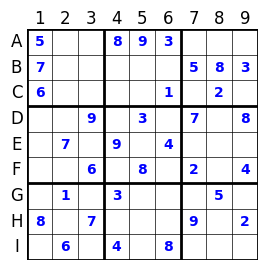

In [ ]:
matrix = SudokuMatrix('tablero_facil.txt')
matrix.graph_board()

# Agente inteligente que resuelve el Sudoku

[Técnica del Par Desnudo](https://www.sudoku.academy/es/learn/naked-pairs/)

[Tecnica de los trillos desnudos](https://www.sudoku.academy/es/learn/naked-triples/)

In [109]:
class SudokuAgent:
    
    def _fill_board(sudoku_board:SudokuMatrix):
        for key, value in sudoku_board.board.items():
            for i in range(9):
                if (key, i) not in sudoku_board.locked_cells and (value[i] == 0 or isinstance(value[i], str)):
                    value[i] = '123456789'
                    posibles = [str(n) for n in range(1, 10) if sudoku_board._validate_play(key, i, n)]
                    value[i] = ''.join(posibles)
        return sudoku_board

    @classmethod
    def only_choise(cls, sudoku_board:SudokuMatrix, naked:bool=False, view_board:bool=True):
        LETTERS = 'ABCDEFGHI'
        lock = False
        solved = False
        sudoku_board.graph_board() if view_board else None
        
        while not lock and not solved:
            previous = {k: v.copy() for k, v in sudoku_board.board.items()}
            cls._fill_board(sudoku_board) if not naked else None
            sudoku_board.graph_board() if view_board else None

            filled = 0
            for row in LETTERS:
                for i in range(9):
                    val = sudoku_board.board[row][i]
                    if isinstance(val, int):
                        filled += 1
                        continue
                    if len(val) == 1:
                        if val.isdigit() and sudoku_board._validate_play(row, i, int(val)):
                            sudoku_board.board[row][i] = int(val)
                        else:
                            raise ValueError(f"Invalid move at {row}{i} with value {val}")
                    elif len(val) == 0:
                        lock = True
            
            if previous == sudoku_board.board:
                lock = True
            if filled == 81:
                solved = True

        return sudoku_board

    @staticmethod
    def _is_pair(value:str) -> bool:
        return isinstance(value, str) and len(value) == 2

    @staticmethod
    def _get_elements():
        LETTERS = "ABCDEFGHI"
        units = []

        for row in LETTERS:
            units.append([(row, col) for col in range(9)])

        for col in range(9):
            units.append([(row, col) for row in LETTERS])

        for box_row in range(0, 9, 3):
            for box_col in range(0, 9, 3):
                units.append([
                    (LETTERS[box_row + i], box_col + j)
                    for i in range(3) for j in range(3)
                ])
        return units

    @staticmethod
    def _find_naked_twins(sudoku_board:SudokuMatrix, unit):
        seen = {}
        twins = []

        for (f, c) in unit:
            val = sudoku_board.board[f][c]
            if isinstance(val, str) and len(val) == 2:
                key = frozenset(val)
                if key in seen:
                    other = seen[key]
                    twins.append((key, [(f, c), other]))
                else:
                    seen[key] = (f, c)

        return twins

    @staticmethod
    def _delete_numbers_pair(sudoku_board:SudokuMatrix, unit, pair, cells):
        for (f, c) in unit:
            if (f, c) in cells:
                continue
            val = sudoku_board.board[f][c]
            if isinstance(val, str) and len(val) > 1:
                nueva = ''.join(sorted(set(val) - pair))
                if nueva != val:
                    print(f"Eliminando {pair} de ({f}{c}): '{val}' -> '{nueva}'")
                    sudoku_board.board[f][c] = nueva

    @classmethod
    def _solve_naked_twins(cls, sudoku_board:SudokuMatrix):
        for unit in cls._get_elements():
            twins = cls._find_naked_twins(sudoku_board, unit)
            for pair, cells in twins:
                
                print(f"Par gemelo: {cells[0][0], cells[0][1]+1} y {cells[1][0], cells[1][1]+1} con valores {set(pair)}")
                cls._delete_numbers_pair(sudoku_board, unit, set(pair), cells)
        return sudoku_board

    @classmethod
    def solve_sudoku(cls, sudoku_board:SudokuMatrix):
        previous_board = {}
        sudoku_board.graph_board()
        cls._fill_board(sudoku_board)

        while True:
            if previous_board == sudoku_board.board:
                break
            previous_board = {k: v.copy() for k, v in sudoku_board.board.items()}

            cls.only_choise(sudoku_board, naked=True, view_board=False)
            cls._fill_board(sudoku_board)
            cls._solve_naked_twins(sudoku_board)

            if previous_board != sudoku_board.board:
                sudoku_board.graph_board()

        return sudoku_board


## Sudoku Facil

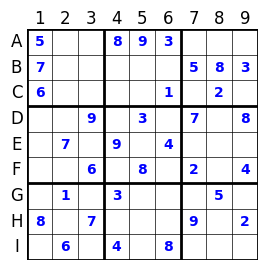

In [111]:
matrix = SudokuMatrix('tablero_facil.txt')
matrix.graph_board()

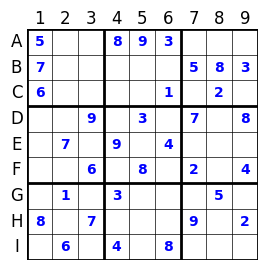

Par gemelo: ('B', 6) y ('B', 4) con valores {'6', '2'}
Eliminando {'6', '2'} de (B1): '249' -> '49'
Eliminando {'6', '2'} de (B2): '124' -> '14'
Eliminando {'6', '2'} de (B4): '246' -> '4'
Par gemelo: ('C', 5) y ('C', 4) con valores {'7', '5'}
Eliminando {'7', '5'} de (C8): '79' -> '9'
Par gemelo: ('H', 2) y ('F', 2) con valores {'3', '5'}
Eliminando {'3', '5'} de (C1): '389' -> '89'
Eliminando {'3', '5'} de (D1): '245' -> '24'
Par gemelo: ('B', 6) y ('B', 4) con valores {'6', '2'}
Par gemelo: ('C', 5) y ('C', 4) con valores {'7', '5'}


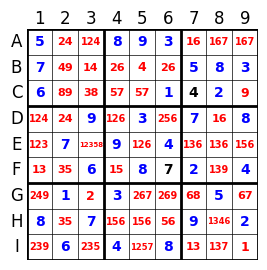

Par gemelo: ('B', 6) y ('B', 4) con valores {'6', '2'}
Eliminando {'6', '2'} de (B1): '29' -> '9'
Par gemelo: ('C', 3) y ('C', 2) con valores {'3', '8'}
Par gemelo: ('C', 5) y ('C', 4) con valores {'7', '5'}
Par gemelo: ('G', 9) y ('G', 5) con valores {'6', '7'}
Eliminando {'6', '7'} de (G5): '69' -> '9'
Eliminando {'6', '7'} de (G6): '68' -> '8'
Par gemelo: ('H', 2) y ('F', 2) con valores {'3', '5'}
Eliminando {'3', '5'} de (C1): '38' -> '8'
Eliminando {'3', '5'} de (D1): '245' -> '24'
Par gemelo: ('D', 4) y ('B', 4) con valores {'6', '2'}
Eliminando {'6', '2'} de (H3): '156' -> '15'
Par gemelo: ('H', 6) y ('D', 6) con valores {'6', '5'}
Eliminando {'6', '5'} de (B5): '26' -> '2'
Par gemelo: ('G', 9) y ('A', 9) con valores {'6', '7'}
Eliminando {'6', '7'} de (E8): '56' -> '5'
Par gemelo: ('C', 5) y ('C', 4) con valores {'7', '5'}
Par gemelo: ('I', 3) y ('H', 2) con valores {'3', '5'}
Eliminando {'3', '5'} de (I0): '39' -> '9'


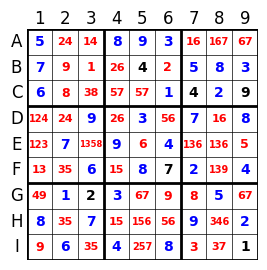

Par gemelo: ('C', 5) y ('C', 4) con valores {'7', '5'}
Par gemelo: ('H', 2) y ('F', 2) con valores {'3', '5'}
Eliminando {'3', '5'} de (D1): '245' -> '24'
Par gemelo: ('C', 5) y ('C', 4) con valores {'7', '5'}


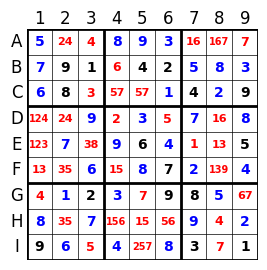

Par gemelo: ('H', 5) y ('H', 4) con valores {'1', '5'}
Par gemelo: ('H', 5) y ('H', 4) con valores {'1', '5'}


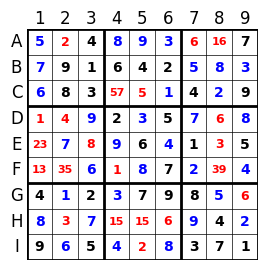

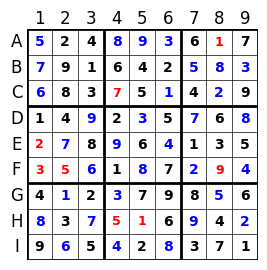

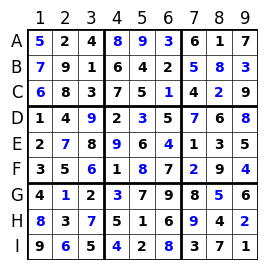

In [112]:
SudokuAgent.solve_sudoku(matrix)

## Sudoku Con Naked Twins

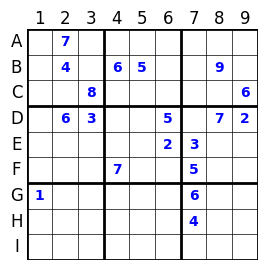

In [114]:
twins_matrix = SudokuMatrix('tablero_facil_naked_twins.txt')
twins_matrix.graph_board()

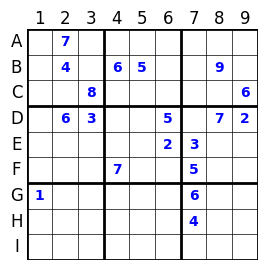

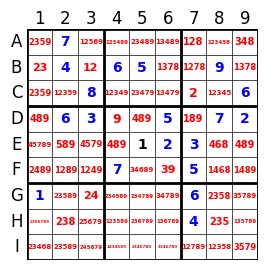

Par gemelo: ('D', 5) y ('D', 1) con valores {'8', '4'}
Eliminando {'8', '4'} de (D6): '18' -> '1'
Par gemelo: ('E', 4) y ('D', 5) con valores {'8', '4'}
Eliminando {'8', '4'} de (F4): '3468' -> '36'


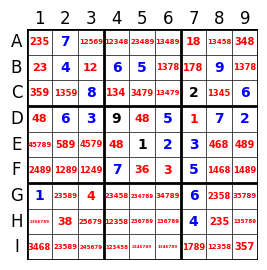

Par gemelo: ('D', 5) y ('D', 1) con valores {'8', '4'}
Par gemelo: ('E', 4) y ('D', 5) con valores {'8', '4'}
Eliminando {'8', '4'} de (F4): '468' -> '6'


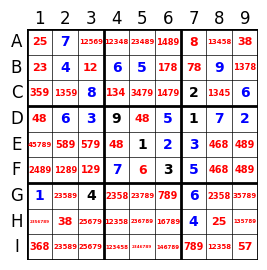

Par gemelo: ('D', 5) y ('D', 1) con valores {'8', '4'}
Par gemelo: ('E', 4) y ('D', 5) con valores {'8', '4'}


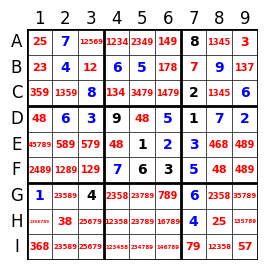

Par gemelo: ('D', 5) y ('D', 1) con valores {'8', '4'}
Par gemelo: ('E', 4) y ('D', 5) con valores {'8', '4'}


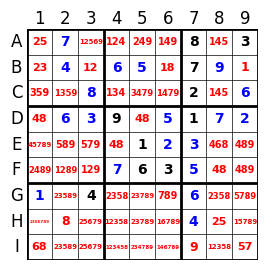

Par gemelo: ('D', 5) y ('D', 1) con valores {'8', '4'}
Par gemelo: ('C', 8) y ('A', 8) con valores {'5', '4'}
Eliminando {'5', '4'} de (E7): '468' -> '68'
Eliminando {'5', '4'} de (F7): '48' -> '8'
Eliminando {'5', '4'} de (G7): '2358' -> '238'
Eliminando {'5', '4'} de (H7): '25' -> '2'
Eliminando {'5', '4'} de (I7): '12358' -> '1238'
Par gemelo: ('I', 9) y ('H', 9) con valores {'7', '5'}
Eliminando {'7', '5'} de (G8): '578' -> '8'
Par gemelo: ('C', 8) y ('A', 8) con valores {'5', '4'}
Par gemelo: ('E', 4) y ('D', 5) con valores {'8', '4'}
Par gemelo: ('I', 9) y ('H', 9) con valores {'7', '5'}


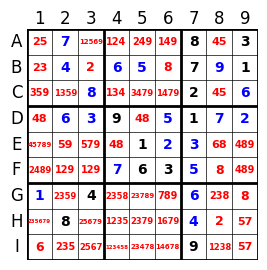

Par gemelo: ('D', 5) y ('D', 1) con valores {'8', '4'}
Par gemelo: ('I', 9) y ('I', 3) con valores {'7', '5'}
Eliminando {'7', '5'} de (I1): '235' -> '23'
Eliminando {'7', '5'} de (I3): '123458' -> '12348'
Eliminando {'7', '5'} de (I4): '23478' -> '2348'
Eliminando {'7', '5'} de (I5): '147' -> '14'
Eliminando {'7', '5'} de (I7): '135' -> '13'
Par gemelo: ('C', 8) y ('A', 8) con valores {'5', '4'}
Eliminando {'5', '4'} de (E7): '46' -> '6'
Eliminando {'5', '4'} de (G7): '35' -> '3'
Par gemelo: ('F', 9) y ('E', 9) con valores {'9', '4'}
Par gemelo: ('I', 9) y ('H', 9) con valores {'7', '5'}
Par gemelo: ('C', 8) y ('A', 8) con valores {'5', '4'}
Par gemelo: ('E', 4) y ('D', 5) con valores {'8', '4'}
Par gemelo: ('F', 9) y ('E', 9) con valores {'9', '4'}
Par gemelo: ('I', 9) y ('H', 9) con valores {'7', '5'}


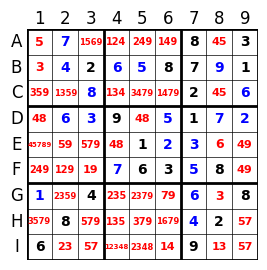

Par gemelo: ('D', 5) y ('D', 1) con valores {'8', '4'}
Par gemelo: ('F', 9) y ('E', 9) con valores {'9', '4'}
Par gemelo: ('E', 4) y ('D', 5) con valores {'8', '4'}
Par gemelo: ('F', 9) y ('E', 9) con valores {'9', '4'}


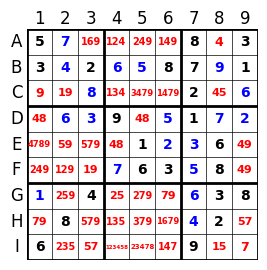

Par gemelo: ('D', 5) y ('D', 1) con valores {'8', '4'}
Par gemelo: ('F', 9) y ('E', 9) con valores {'9', '4'}
Par gemelo: ('E', 4) y ('D', 5) con valores {'8', '4'}
Par gemelo: ('F', 9) y ('E', 9) con valores {'9', '4'}


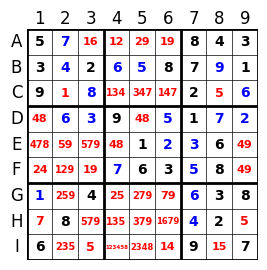

Par gemelo: ('D', 5) y ('D', 1) con valores {'8', '4'}
Par gemelo: ('E', 4) y ('E', 1) con valores {'8', '4'}
Eliminando {'8', '4'} de (E8): '49' -> '9'
Par gemelo: ('E', 1) y ('D', 1) con valores {'8', '4'}
Eliminando {'8', '4'} de (F0): '24' -> '2'
Par gemelo: ('G', 2) y ('F', 2) con valores {'2', '9'}
Eliminando {'2', '9'} de (E1): '59' -> '5'
Eliminando {'2', '9'} de (I1): '23' -> '3'
Par gemelo: ('E', 1) y ('D', 1) con valores {'8', '4'}
Par gemelo: ('E', 4) y ('D', 5) con valores {'8', '4'}


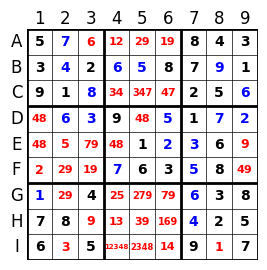

Par gemelo: ('D', 5) y ('D', 1) con valores {'8', '4'}
Par gemelo: ('E', 4) y ('E', 1) con valores {'8', '4'}
Par gemelo: ('E', 1) y ('D', 1) con valores {'8', '4'}
Par gemelo: ('E', 1) y ('D', 1) con valores {'8', '4'}
Par gemelo: ('E', 4) y ('D', 5) con valores {'8', '4'}


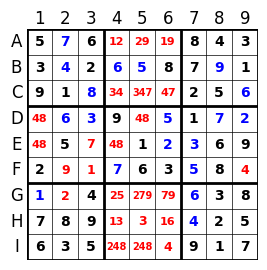

Par gemelo: ('D', 5) y ('D', 1) con valores {'8', '4'}
Par gemelo: ('E', 4) y ('E', 1) con valores {'8', '4'}
Par gemelo: ('G', 6) y ('G', 5) con valores {'7', '9'}
Par gemelo: ('I', 5) y ('I', 4) con valores {'2', '8'}
Par gemelo: ('E', 1) y ('D', 1) con valores {'8', '4'}
Par gemelo: ('E', 1) y ('D', 1) con valores {'8', '4'}
Par gemelo: ('E', 4) y ('D', 5) con valores {'8', '4'}
Par gemelo: ('G', 6) y ('G', 5) con valores {'7', '9'}
Par gemelo: ('I', 5) y ('I', 4) con valores {'2', '8'}


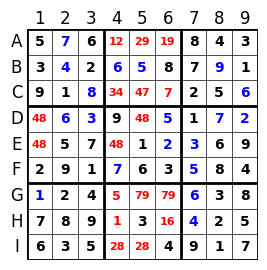

Par gemelo: ('D', 5) y ('D', 1) con valores {'8', '4'}
Par gemelo: ('E', 4) y ('E', 1) con valores {'8', '4'}
Par gemelo: ('I', 5) y ('I', 4) con valores {'2', '8'}
Par gemelo: ('E', 1) y ('D', 1) con valores {'8', '4'}
Par gemelo: ('E', 1) y ('D', 1) con valores {'8', '4'}
Par gemelo: ('E', 4) y ('D', 5) con valores {'8', '4'}
Par gemelo: ('I', 5) y ('I', 4) con valores {'2', '8'}


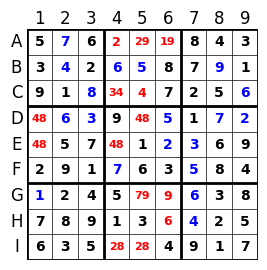

Par gemelo: ('E', 4) y ('E', 1) con valores {'8', '4'}
Par gemelo: ('E', 1) y ('D', 1) con valores {'8', '4'}
Par gemelo: ('E', 1) y ('D', 1) con valores {'8', '4'}


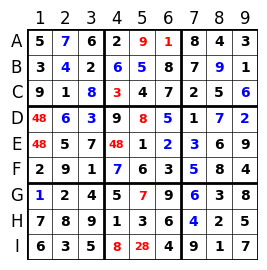

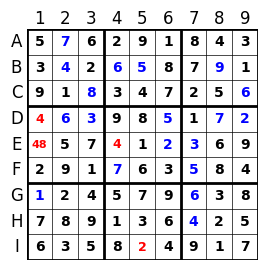

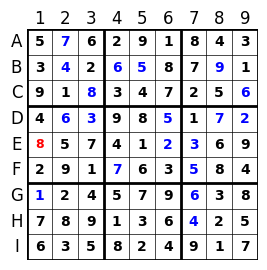

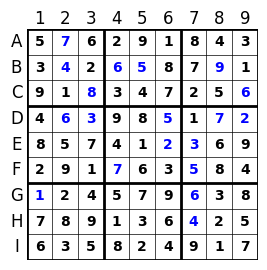

In [116]:
SudokuAgent.solve_sudoku(twins_matrix)